Before we can run this, we need to go to Anaconda and do:

conda activate pytorch

Then:

python -m jupyterlab

# Setting up our Notebook

In [24]:
import random
import numpy as np
import torch
import torch.nn as nn
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from collections import deque
import pandas as pd

# RL
from gym import Env
from gym.spaces import Discrete, Box
import random
import torch.nn.functional as F

# CNN
import torch.nn as nn
from torch.optim import Adam

%matplotlib inline


# Importing the data

In [25]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Double Deep Q-Network with Multi-Layer Perceptron and Prioritized Experience Replay

## Getting the train/test data

In [3]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_test 
    X_test=scaler.transform(X_test)

    # Transforming the X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [4]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print(X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]
print(y_test)

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)
[ 0.61446374  0.80874465  0.50518634 ...  0.98700007 -0.01400845
 -0.23385943]


In [5]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(y[i-n_steps+11])
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [6]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
print(y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

[ 0.29675316 -0.8274389   0.47853097 ...  0.37927447  0.98700007
 -0.01400845]
X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [7]:
# print(y_train)
# print(y)
print(X_train[0],y_train[0])

[[[-3.48131856e+00  2.32702870e+00  1.09005036e-02 -3.05954125e+00
   -2.85645115e-01  8.96446781e-01  7.40932602e-01 -2.55452464e-01
   -9.72525663e-01 -1.57582953e+00  5.44588741e-01 -6.88520313e-02
    4.69687833e-01 -4.49557036e-01 -1.12239006e+00  1.12332131e+00
   -5.37782977e-01 -1.56128667e-01 -2.12577550e-01 -7.09511086e-01]
  [-3.40993583e+00  1.04015526e+00  1.68968189e+00 -3.98142807e+00
   -5.22621186e-01  1.55378608e+00  9.18077486e-01  2.87289026e-01
   -4.34854556e-01 -1.13170902e+00  5.81258009e-01  9.58746300e-02
    9.23525455e-01 -2.38887111e-01 -1.58935155e+00  1.12190979e+00
   -1.69590593e-01 -3.12505963e-01 -4.14320370e-02 -1.01523990e+00]
  [-3.39991632e+00  4.76772294e-01  1.74111349e+00 -3.39636618e+00
   -7.61787916e-01  9.53808346e-01  2.75988534e-01  6.28302730e-01
    5.50425804e-01 -9.56884664e-01  6.13056959e-01  8.26542561e-02
    1.30336396e+00 -2.34316176e-01 -1.89510908e+00  1.28796476e+00
   -5.66557100e-03 -2.91436847e-01 -1.36210856e-01 -1.076662

## Financial Environment

In [8]:
class FinEnv(Env):
    # A custom Bitcoin trading environment
    def __init__(self, df, y, initial_balance=1000):
        # Define action space and state size and other custom parameters
        self.df = df
        self.y = y
        self.df_total_steps = len(self.df) # How many steps we can possibly take
        self.initial_balance = initial_balance # How much we start with
        self.holding_asset = 0 # We use this to indicate if we are holding an asset or not. 0 is No, 1 is Yes
        self.actions_taken=[] # Keeping a log of our actions
        
        # Orders history contains the our net worth at each step
        self.orders_history = deque(maxlen=self.df_total_steps)
        
        # Market history contains the current market values
        self.market_history = deque(maxlen=1)

        # Action space. 1 is Buy and 0 is Sell
        self.action_space = np.array([0, 1])

        # State size contains the 20 PCA data points per time for 12 time slices
        self.state_size = df[0].shape

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size=0):
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.holding_asset = 0 # We are not holding anything in the beginning
        self.actions_taken=[] # Keeping a log of our actions
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(0, self.df_total_steps - env_steps_size) # Picks a random step to start from
            self.end_step = self.start_step + env_steps_size # Runs from the randomly chosen step to that step+env_steps we want
        else: # used for testing dataset
            self.start_step = 0
            self.end_step = self.df_total_steps-1

        self.current_step = self.start_step

        self.state = self.df[self.current_step] # State is the state of the market
        # print('Beginning State', self.state)

        return self.state

    # Get the data points for the given current_step
    def _next_observation(self):
        obs = self.df[self.current_step] # Will be what the nn sees to make a decision
        # print('Obs next_observation', obs)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        # print('Action', action)
        # Percent Change
        self.percent_change=self.y[self.current_step]
        # print('Percent Change on this step', self.percent_change)
        
        if action == 1 and self.holding_asset == 0: # Enter the market with all of your current net worth. It is affected
            # by the percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            self.holding_asset = 1 # You are now holding an asset
            self.actions_taken.append('Bought')
            
        elif action == 1 and self.holding_asset == 1: # You already bought and are waiting to sell. It is affected by the 
            # percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            # Your holding_asset does not change
            self.actions_taken.append('Buy signal, but we are waiting to sell')
            pass

        elif action == 0 and self.holding_asset == 1: # You leave the market
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            self.holding_asset = 0 # You are no longer holding any assets
            self.actions_taken.append('Sold')
            
        elif action==0  and self.holding_asset == 0: # You already sold and are waiting for a buy signal
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            # Your holding_asset does not change
            self.actions_taken.append('Sell signal, but we are waiting to buy')
            pass
        # Reward
        reward=self.net_worth-self.prev_net_worth # Our reward is the change in our net worth
        
        # Updating our prev_net_worth
        self.prev_net_worth = self.net_worth # Updating our prev_net_worth for the next time step
        # print('Net worth after market acts', self.prev_net_worth)

        self.orders_history.append([self.net_worth]) # Adding our net worth to our orders_history
        
        # Leave the market if we have lost half our money
        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        # Stepping into the next state
        if self.current_step == self.end_step:
            # print('We are done stepping', self.current_step)
            obs=[]
            done = True
        else:    
            self.current_step += 1    
            obs = self._next_observation() # Moves us to the next observation
        
        # Set net worths as info so we can retrieve it at the end
        info = self.orders_history
        
        # Return step information   
        return obs, reward, done, info
    # render environment
    def render(self, mode='human'): # 'mode=human' is required for the Keras-RL package
        print(f'Step: {self.current_step}, Beginning Net Worth: {self.net_worth}')

## Random Games

In [28]:
def Random_games(env, episodes = 50, steps=1000):
    for episode in range(episodes): # Runs through however many number of training episodes
        state = env.reset(env_steps_size = steps) # Sets the env_step_size to the batch size

        while True:
            # env.render()

            action = np.random.randint(2, size=1)[0]

            state, reward, done, info = env.step(action)
            # print('Reward', reward)
            # print('End Net Worth', info[-1])
            

            if env.current_step == env.end_step:
                print(len(info))
                break

In [29]:
# Playing a random game to confirm our environment is working

# Setting up the environment
df=X_test
y=y_test
train_env = FinEnv(df, y)

# Random Game
Random_games(train_env, episodes = 1, steps=0)

4367


In [11]:
# print(X_train[0], y_train[0])
# print(X_train[1], y_train[1])
print(X_train[4])
print(y_train[:5])

[[[-3.35157423e+00 -7.56470673e-01  6.72454132e-01 -1.24365283e+00
   -1.02199762e+00  2.30997592e-02 -1.01392492e+00  7.53642326e-01
    8.41535374e-01 -1.96468735e+00  4.01056759e-01  7.55346493e-01
    7.30076563e-01 -4.26384234e-01 -1.57397127e+00  1.38363683e+00
   -1.01625149e+00  2.81638526e-01  4.93213584e-04 -5.21345837e-01]
  [-3.31211531e+00 -1.69387919e+00  1.63737759e+00 -1.17212534e+00
   -1.33331851e+00 -1.08904355e-01 -1.34060632e+00  1.94599283e+00
   -1.05351916e-01 -2.04559041e+00  3.95366061e-01  7.12250574e-01
    1.28448308e-01  5.88758125e-02  1.10478197e+00 -7.31771129e-02
   -4.23582192e-02  2.62790090e-02 -2.57610603e-01 -1.19186742e-01]
  [-3.30539280e+00 -1.41102404e+00  1.33843289e+00 -1.50733453e+00
   -1.12573164e+00  3.93226445e-01 -5.13452836e-01  8.23740314e-01
    3.87497738e-01 -7.40850536e-01  4.71535766e-01 -1.11810864e+00
    5.19980336e-01 -5.27031607e-01  1.88337017e+00  1.36393417e-01
    9.03323471e-01  1.45189418e+00 -1.12198585e+00 -8.459791

## Building the network

### Dueling DQN

In [12]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
# Setting up the states and actions
state_shape = train_env.state_size
n_actions = len(train_env.action_space)
print('State Shape',state_shape)
print('Number of actions', n_actions)

State Shape (1, 12, 20)
Number of actions 2


In [14]:
# Creating the Dueling DQN Agent

class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Conv and Pool Network
    
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        # MLP Network for both Value and Advantage go through

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))

        # Value Layer
        self.value = nn.Linear(512, 1)

        # Advantage Layer
        self.adv = nn.Linear(512, n_actions)

    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        x = self.conv_network(state_t)
        x = self.fc_network(x)
        v = self.value(x)
        adv = self.adv(x)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        qvalues = v + adv - adv_avg
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [15]:
# Instantiation of the agent

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [16]:
# Evaluation function

def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, info = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards), info

# Prioritized Experience replay

In [17]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha=0.6, beta=0.4):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
        self.alpha = alpha
        self.beta = beta
        self.priorities = np.ones(size)
        self.epsilon = 1e-5
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        max_priority = self.priorities.max()
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.priorities[self.next_id] = max_priority
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        N = len(self.buffer)
        weights = (N * probabilities) ** (-self.beta)
        weights /= weights.max()

        idxs = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        weights = weights[idxs]
        
        
        return  (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(done_flags), np.array(weights), np.array(idxs))
        
    def update_priorities(self, idxs, new_priorities):
        self.priorities[idxs] = new_priorities+self.epsilon

In [18]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network

In [19]:
target_network = DuelingDQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with Double DQN

In [20]:
def compute_td_loss_priority_replay_ddqn(agent, target_network, replay_buffer,
                                    states, actions, rewards, next_states, done_flags, weights, buffer_idxs,
                                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)
    weights = torch.tensor(weights, device=device, dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]
    
    # Same up to here as the regular DQN

    # compute q-values for all actions in next states
    # use agent network (online network)
    qvalues_next_states = agent(next_states).detach()
    
    # compute Q argmax(next_states, actions) using predicted next q-values
    _,a1max = torch.max(qvalues_next_states, dim=1)

    #use target network to calculate the q value for best action chosen above
    qvalues_next_states_target = target_network(next_states)

    qvalues_next_states_target_max = qvalues_next_states_target[range(len(a1max)), a1max]

    # compute "target q-values" 
    target_q = rewards + gamma * qvalues_next_states_target_max * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_q).pow(2))

    return loss

## Main loop

In [21]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [22]:
# set a seed
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [23]:
# Setting up the agent, environment, and target networks

df=X_train
y=y_train
train_env = FinEnv(df, y)
state_shape = train_env.state_size
n_actions = len(train_env.action_space)
print('State Shape',state_shape)
print('Number of actions', n_actions)

state = train_env.reset()

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

State Shape (1, 12, 20)
Number of actions 2


<All keys matched successfully>

In [24]:
# let us fill experience replay with some samples using full random policy

exp_replay = PrioritizedReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, train_env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print('Number of experiences in Prioritized Replay Buffer',len(exp_replay))

C:\Users\chris\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


Number of experiences in Prioritized Replay Buffer 10000


In [25]:
# Training parameters

timesteps_per_epoch = 1
batch_size = 32
total_steps = 40000

# Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

# Exploration Epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# Frequency for logging and updating
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# Gradient Clipping
max_grad_norm = 5000

# Logging
mean_rw_history = []
td_loss_history = []

In [26]:
# Epsilon Schedule and Smoothening functions

def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.05000


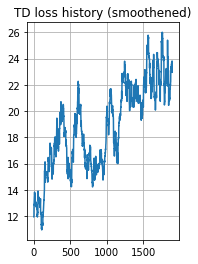

100%|████████████████████████████████████████████████████████████████████████████| 40001/40001 [53:00<00:00, 12.58it/s]


In [27]:
# Training

state = train_env.reset()
for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, train_env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags, weights, idxs = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss_priority_replay_ddqn(agent, target_network, exp_replay,
                           states, actions, rewards, next_states, done_flags, weights, idxs,              
                           gamma=0.5,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(train_env, agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

#         plt.figure(figsize=[16, 5])
#         plt.subplot(1, 2, 1)
#         plt.title("Mean reward per episode")
#         plt.plot(mean_rw_history)
#         plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

Text(0.5, 1.0, 'Smoothened TD Loss')

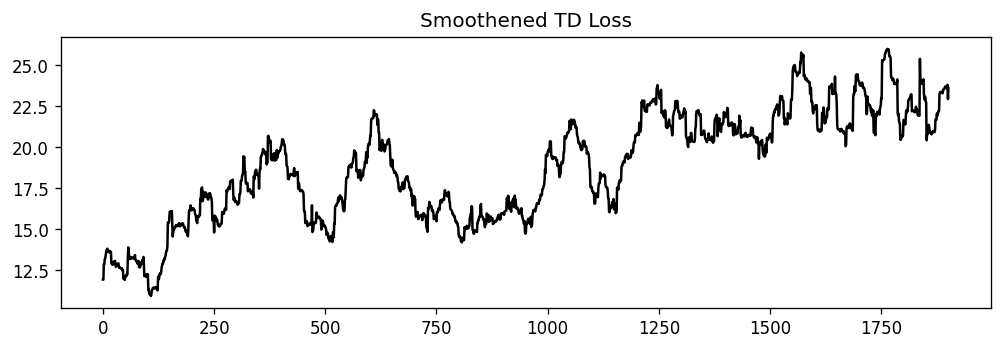

In [32]:
TD_Loss=smoothen(td_loss_history)
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(TD_Loss, color='black')
plt.title('Smoothened TD Loss')

### Performance Evaluation

#### Training Environment

In [28]:
n_games=1
t_max=len(X_train)-1

final_score, net_worths = evaluate(
  train_env,
  agent, n_games=n_games, greedy=True, t_max=t_max
)
print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)

Average Rewards after 26263 steps in 1 game(s) is: 4291.8730712107945


#### Testing Environment

In [29]:
df=X_test
y=y_test
max_length=len(df)
test_env = FinEnv(df, y)

n_games=1
t_max=max_length

final_score, net_worths = evaluate(
  test_env,
  agent, n_games=n_games, greedy=True, t_max=t_max
)
print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)

Average Rewards after 4368 steps in 1 game(s) is: 298.8344719057475


4368


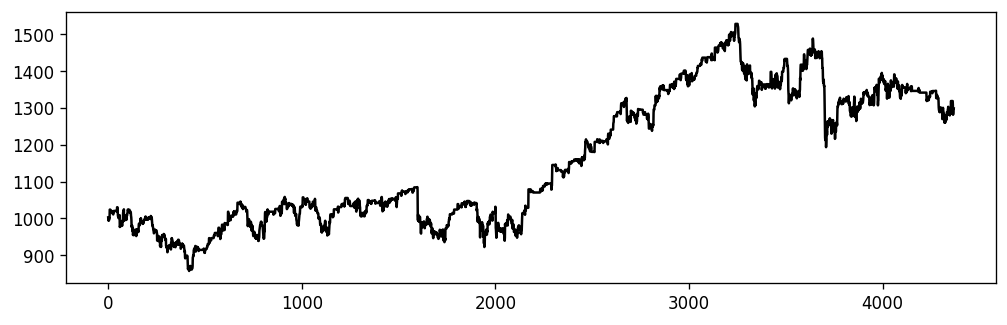

In [30]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(net_worths, color='black')
print(len(net_worths))

In [31]:
# Saving and agent

# torch.save(agent, 'Models/CNN DQN gamma_0.95 BTC.h5')

In [27]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.15 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [38]:
# Models to evaluate

models=['Models/CNN DQN gamma_0 BTC.h5', 'Models/CNN DQN gamma_0.15 BTC.h5', 'Models/CNN DQN gamma_0.25 BTC.h5',
       'Models/CNN DQN gamma_0.35 BTC.h5', 'Models/CNN DQN gamma_0.5 BTC.h5', 'Models/CNN DQN gamma_0.75 BTC.h5',
       'Models/CNN DQN gamma_0.8 BTC.h5', 'Models/CNN DQN gamma_0.9 BTC.h5', 'Models/CNN DQN gamma_0.95 BTC.h5',
       'Models/CNN DQN gamma_1 BTC.h5']

In [39]:
# Evaluating our models

for model in models:
    print(model)
    agent = torch.load(model)
    df=X_test
    y=y_test
    max_length=len(df)
    test_env = FinEnv(df, y)

    n_games=10
    t_max=max_length

    final_score, net_worths = evaluate(
      test_env,
      agent, n_games=n_games, greedy=True, t_max=t_max
    )
    print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)
    print('\n')


Models/CNN DQN gamma_0 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 473.22256522319896


Models/CNN DQN gamma_0.15 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 394.92323546707684


Models/CNN DQN gamma_0.25 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 468.01578672468185


Models/CNN DQN gamma_0.35 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 422.5513555240981


Models/CNN DQN gamma_0.5 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 537.4180504349222


Models/CNN DQN gamma_0.75 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 380.3428333977229


Models/CNN DQN gamma_0.8 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 403.14934499472747


Models/CNN DQN gamma_0.9 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 290.6628778030614


Models/CNN DQN gamma_0.95 BTC.h5
Average Rewards after 4368 steps in 10 game(s) is: 217.46221253520488


Models/CNN DQN gamma_1 BTC.h5
Average Rewards after 4368 steps in

We see that the best model is the one with $\gamma=0.5$